<a href="https://colab.research.google.com/github/DrAlexSanz/Electricity-prices/blob/main/Feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from google.colab import drive

In [2]:
drive.mount('/gdrive')

Mounted at /gdrive


In [62]:
data = pd.read_csv('/gdrive/MyDrive/Electricity_prices/for_features.csv', parse_dates = True)
data["time"] = pd.to_datetime(data["time"])

## Feature engineering

**What is important for the electricity price?**


*   Weekday or weekend. I will generate two columns, weekend = 0/1 and weekday = 0/1.
*   Special events, like holidays, football matches and similar things.
*   Load and generation, I already have those columns.
*   Weather information, I already have those columns.
*   Taxes, carbon emissions right, and all those things. I don't want to get into all this mess. Electricity companies consider these things in their models.

**What features can I discard?**

Based on the correlation matrix and common sense. [Time_series_stationality](https://github.com/DrAlexSanz/Electricity-prices/blob/main/Time_series_stationality.ipynb)

*   If I have the hourly temperature, the min/max temperatures will not give me a lot of new information. I removed them in the cleaning stage.

*   The temperatures and pressures in different cities are correlated because at these scales they vary very smoothly. Pressure and temperature also impact the rain and snow. Since I don't have a lot of knowledge about how all this variables interact, and the interaction will be highly non-linear, I will leave them.

*  I can't combine different energy generation features. They are all correlated by the market but there is no equation on how to combine them. Only nuclear in the base, renewables offered at 0 and the combined cycles and hydro for quick response, peak shaving and rolling reserves.

**I will also do a PCA decomposition and see how many of the PCA features I would need to explain 80-90% of the variance, out of curiosity mostly.**

In [63]:
data["weekend"] = 0 # No need to apply another condition later.
data.loc[data["time"].dt.weekday >= 5, "weekend"] = 1

#### Now that I have all the features and everything that I want created I will split in train/test/validation(80/10/10).

These values are reasonable but I could do 95/5/5 or something else. I know that seasonality is daily and yearly.

In [69]:
train_limit = 28051 #Hard coded based on 80% and 90%
test_limit = 31557

x_train = data.iloc[:train_limit]
x_test = data.iloc[train_limit:test_limit]
x_val = data.iloc[test_limit:]

x_train = x_train.drop("price actual", axis = 1)
x_test = x_test.drop("price actual", axis = 1)
x_val = x_val.drop("price actual", axis = 1)

y_train = data["price actual"].iloc[:train_limit]
y_test = data["price actual"].iloc[train_limit:test_limit]
y_val = data["price actual"].iloc[test_limit:]

### (Scaling and) PCA decomposition

Need to scale my data before the PCA, generations can be in 1000s of MW and temperatures in 10s. If I don't scale I get a sorting of the variables by importance.

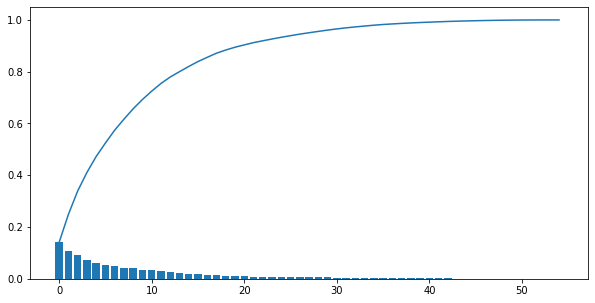

In [72]:
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

x_pca_no_dt = x_train.drop("time", axis = 1)

x_train_pca = scaler_x.fit_transform(x_pca_no_dt)

pca = PCA()

x_pca = pca.fit(x_train_pca)

num_components = len(pca.explained_variance_ratio_)

plt.figure(figsize = (10, 5))

plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()

In [77]:
# I need 14-15 variables to explain 80% of the variance and 21 to explain 90%. I have 55 total components.

for count, var in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    print("With " + str(count + 1) + " components I can explain " + str(round(var * 100, 2)) + "% of the variance")

With 1 components I can explain 14.09% of the variance
With 2 components I can explain 24.88% of the variance
With 3 components I can explain 33.9% of the variance
With 4 components I can explain 41.07% of the variance
With 5 components I can explain 47.25% of the variance
With 6 components I can explain 52.46% of the variance
With 7 components I can explain 57.42% of the variance
With 8 components I can explain 61.66% of the variance
With 9 components I can explain 65.69% of the variance
With 10 components I can explain 69.28% of the variance
With 11 components I can explain 72.49% of the variance
With 12 components I can explain 75.46% of the variance
With 13 components I can explain 77.95% of the variance
With 14 components I can explain 80.02% of the variance
With 15 components I can explain 82.03% of the variance
With 16 components I can explain 83.93% of the variance
With 17 components I can explain 85.57% of the variance
With 18 components I can explain 87.16% of the variance
Wi